# Pre Processing

This ipynb file consists of description on vanilla method of data-preprocessing step, most of future input data would be processing using these mehotds


In [2]:
import torch
from torch.utils.data import Dataset

##File Management

import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


#Image,Numpy
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Img Augment
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from torchvision import transforms as T


## Load Data
    
We use [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

The dataset is structured in xml format and is structured by follpwing method:

```
Rootdir
│   
│   
│
└───annotations
│   │   list.txt
│   │   test.txt
│   │   trainval.txt
│   └───trimaps #Segmentation Map
│   │   │   _Abyssinian_1.png
│   │   │   _Abyssinian_2.png
│   │   │   ...
│   │
│   └───xmls   #File information including boundary box 
│       │  Abyssinian_1.xml
│       │  Abyssinian_2.xml
│
└───images
    │   Abyssinian_1.jpg
    │   Abyssinian_2.jpg
    │   ...
```



We first import  list of xmls to dataframe, we used some of the codes from [Benhime91-pytorch_example](https://github.com/benihime91/pytorch_examples)

In [3]:
def xml_to_csv(pths):
    '''pths: list of xml_files'''
    CLASS_NAME=['cat','dog']  #We only have two classes, but could be changed in future

    xml_list = []
    for xml_file in pths:
        # Read in the xml file
        tree = ET.parse(xml_file)
        path = os.path.join(img_path, tree.findtext("./filename"))
        height = int(tree.findtext("./size/height"))
        width = int(tree.findtext("./size/width"))
        xmin = int(tree.findtext("./object/bndbox/xmin"))
        ymin = int(tree.findtext("./object/bndbox/ymin"))
        xmax = int(tree.findtext("./object/bndbox/xmax"))
        ymax = int(tree.findtext("./object/bndbox/ymax"))
        name = CLASS_NAME.index(tree.findtext("./object/name"))
        xml_list.append([path,name,xmin,ymin,xmax,ymax])
    col_n = ["filename", "target","xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df

In [4]:
root_path="D:/Dataset/Pet_Data/"
img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")
df=xml_to_csv(annots)
df.head()

,filename,target,xmin,ymin,xmax,ymax
0,D:/Dataset/Pet_Data/images\Abyssinian_1.jpg,0,333,72,425,158
1,D:/Dataset/Pet_Data/images\Abyssinian_10.jpg,0,72,105,288,291
2,D:/Dataset/Pet_Data/images\Abyssinian_100.jpg,0,151,71,335,267
3,D:/Dataset/Pet_Data/images\Abyssinian_101.jpg,0,54,36,319,235
4,D:/Dataset/Pet_Data/images\Abyssinian_102.jpg,0,23,27,325,320


## Torch Utils Dataset/Dataloader
We use pytorch type dataset and ue imgaug library to augment the images, since we will use pretrained network, the images will be resized to 224

In [568]:

class PetData(Dataset):

    
    def __init__(self, dataframe,train=False,tensor_return=True):
        self.df=dataframe
        self.tensor_return=tensor_return
        if train:
            self.transform=iaa.Sequential([iaa.Resize((224,224))])

        else:
            self.transform=iaa.Sequential([iaa.Resize((224,224))])
        
        self.torch_transform = T.Compose([T.ToTensor(),
                                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        fn,target,xmin,ymin,xmax,ymax=df.iloc[idx] #
        im=cv2.cvtColor(cv2.imread(fn),cv2.COLOR_BGR2RGB) ##Load Img
        
        class_label=target  ##Class
        bbs=BoundingBoxesOnImage([BoundingBox(xmin,ymin,xmax,ymax,label=class_label)], shape=im.shape) #BBox

        image_aug, bbs_aug = self.transform(image=im, bounding_boxes=bbs) #Transformation
        image_aug=self.torch_transform(image_aug)
        if self.tensor_return:
            bbs_aug=torch.stack([torch.tensor([bb.x1,bb.y1,bb.x2,bb.y2,bb.label]) for bb in bbs_aug])
                
        return image_aug,bbs_aug#,class_label
    

In [569]:
def cvt_bbsTOtensor(bbs):
    return(torch.stack([torch.tensor([bb.x1,bb.y1,bb.x2,bb.y2,bb.label]) for bb in bbs]))

In [564]:

BATCH_SIZE = 20
train_ds = PetData(df, train=True,tensor_return=False)

def collate_fn(batch):
    return tuple(zip(*batch))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

In [565]:
print(f' Data: {train_ds[0][0]}')
print(f'BBox: {train_ds[0][1]}')
#print(f'Label: {train_ds[0][2]}')

 Data: tensor([[[-0.7647, -0.7647, -0.7647,  ..., -0.6471, -0.6627, -0.6784],
         [-0.7725, -0.7569, -0.7490,  ..., -0.6314, -0.6471, -0.6627],
         [-0.7725, -0.7569, -0.7412,  ..., -0.6314, -0.6471, -0.6549],
         ...,
         [-0.9059, -0.8980, -0.8980,  ..., -0.8510, -0.8667, -0.8745],
         [-0.9137, -0.9137, -0.8980,  ..., -0.8667, -0.8745, -0.8824],
         [-0.9137, -0.9216, -0.8980,  ..., -0.8824, -0.8824, -0.8824]],

        [[-0.7020, -0.7020, -0.7020,  ..., -0.5843, -0.6000, -0.6157],
         [-0.7098, -0.6941, -0.6863,  ..., -0.5686, -0.5843, -0.6000],
         [-0.7098, -0.6941, -0.6784,  ..., -0.5686, -0.5843, -0.5922],
         ...,
         [-0.8510, -0.8431, -0.8431,  ..., -0.7882, -0.8039, -0.8118],
         [-0.8588, -0.8588, -0.8431,  ..., -0.8039, -0.8118, -0.8196],
         [-0.8588, -0.8667, -0.8431,  ..., -0.8196, -0.8196, -0.8196]],

        [[-0.7882, -0.7882, -0.7882,  ..., -0.6863, -0.7020, -0.7176],
         [-0.7961, -0.7804, -0.7725,  

## Visualization

Simple Visualization Function

In [566]:
def disp_batch(batch,batch_img=False) :
    '''
    batch: One Batch /One Img
    batch_img: if true: select one random input from a batch, else: process one img
    ''' 
    if batch_img:
        image, target = batch
        n = np.random.randint(0, len(image))
        n=0
        im = image[n].permute(1, 2, 0).numpy()
        bbox=np.concatenate((target[n][0][0],target[n][0][1]))
    else:
        image, target = batch
        im=image.permute(1,2,0).numpy()
        bbox=np.concatenate((target[0][0],target[0][1]))
    

    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]
    fig, ax = plt.subplots()
    ax.imshow(np.array(im)*0.5+0.5)
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False ) )
    
    plt.show()

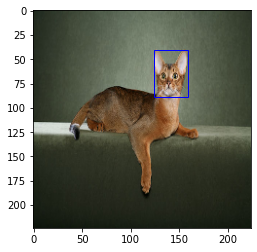

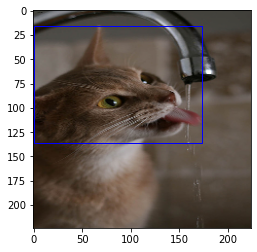

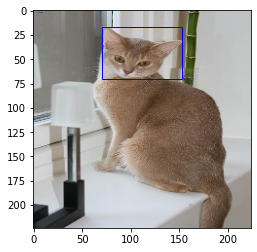

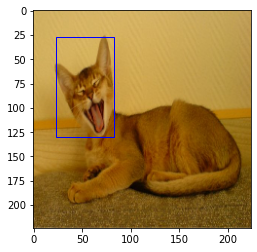

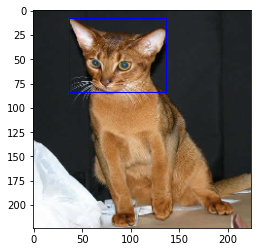

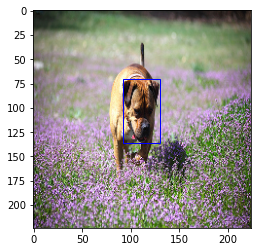

In [567]:
for batch_idx,data in enumerate(train_dl):
    disp_batch(data,batch_img=True)
    if batch_idx==5:
        break